In [1]:
### RUN THIS CELL ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json 
import gmaps
import os
import googlemaps
### RUN THIS CELL ###

In [24]:
### RUN THIS CELL ###

# graphSelectionRates - outputs a bar graph of the selection rates for each protectedClass, depending on the protected
# class you pass in (race or gender). 
# @params: 
#    - selected is a dataframe of all of the candidates that were chosen by the algorithm
#    - candidates is a dataframe containing all candidates
#    - protectedClass is a flag passed in as either "race" or "gender" depending on what the selection rates you'd like
# @return: 
#    - prints selection rates and a bar graph.
def graphSelectionRates(selected, candidates, protectedClass):
    selected_candidates = selected.copy()
    candidates_all = candidates.copy()
    raceIndxs = {"Caucasian": 0, "African-American": 1, "Asian": 2, "Hispanic": 3, "Other": 4 }
    sexIndxs = {"Male":0, "Female":1}
    
    if protectedClass == "race":
        features = [col for col in selected_candidates if col.startswith("race_")]
        race_selected = selected_candidates[features].idxmax(axis=1).str.replace('race_', '')
        race_all = candidates_all[features].idxmax(axis=1).str.replace('race_', '')
        
        candidates_all["Race"] = race_all
        selected_candidates["Race"] = race_selected

        numCandidates = candidates_all["Race"].value_counts()
        numQualified = selected_candidates["Race"].value_counts()
        
        keys = numQualified.keys()
        
        raceToVal = {
            "Caucasian": 0,
            "Asian": 0,
            "African-American": 0,
            "Hispanic": 0,
            "Other": 0
        }
        
        for key in keys:
            raceToVal[key] = numQualified[key]
            
        selectionRate1 = raceToVal["Caucasian"] / numCandidates["Caucasian"]
        selectionRate2 = raceToVal["Asian"] / numCandidates["Asian"]
        selectionRate3 = raceToVal["African-American"] / numCandidates["African-American"]
        selectionRate4 = raceToVal["Hispanic"] / numCandidates["Hispanic"]
        
        print("The selection rate for " + "Caucasian" + "s: ",selectionRate1)
        print("The selection rate for " + "Asian" + "s: ", selectionRate2)
        print("The selection rate for " + "African-American" + "s: ",selectionRate3)
        print("The selection rate for " + "Hispanic" + "s: ",selectionRate4)
        
        y_pos = np.arange(4)
        performance = [selectionRate1, selectionRate2, selectionRate3, selectionRate4]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Caucasian", "Asian", "African-American", "Hispanic"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Race')
        plt.show()
    elif protectedClass == "gender":
        features = [col for col in selected_candidates if col.startswith("gender_")]
        gender_selected = selected_candidates[features].idxmax(axis=1).str.replace('gender_', '')
        gender_all = candidates_all[features].idxmax(axis=1).str.replace('gender_', '')

        candidates_all["Gender"] = gender_all
        selected_candidates["Gender"] = gender_selected
        
        numCandidates = candidates_all["Gender"].value_counts()
        numQualified = selected_candidates["Gender"].value_counts()
        
        print(numCandidates)
        print(numQualified) 
        
        maleSelectionRate = numQualified["male"] / numCandidates["male"]
        femaleSelectionRate = numQualified["female"] / numCandidates["female"]
        print("The selection rate for " + "Male" + "s: ", maleSelectionRate)
        print("The selection rate for " + "Female" + "s: ", femaleSelectionRate)
        y_pos = np.arange(2)
        performance = [maleSelectionRate, femaleSelectionRate]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Male", "Female"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Sex')
        plt.show()
    else:
        print("Try another protected type - gender or race")
        
# getOnehottedDataset - takes a dataframe, a set of features, and prefix names for those features, and one-hots those features.
# Note: ENSURE that the features passed in are discrete/not continuous. 
# @params: 
#    - dataset is a dataframe of individuals you seek to onehot the features of
#    - features is an array of features in the dataset you wish to one-hot
#    - prefixes is an array of names that will be the prefixes of the new columns produced via the one-hot function
# @return: 
#    - returns the dataset with the features, one-hotted.
def getOnehottedDataset(dataset, features, prefixes):
# race, sex, sports, birth origin, education, educational prestige, criminal record, arrest record,
    onehotted_data = dataset.copy()
    onehotted_data = pd.get_dummies(onehotted_data, columns=features, prefix=prefixes)
    return onehotted_data

# transformDatapointsToScale - normalizes the features in the dataset matching with features passed in via selectedFeatures.
# This is done by dividing each of the chosen columns by that columns' max.
# @params:
#    - dataset is a dataframe containing individuals (employees or candidates)
#    - selectedFeatures is an array of strings, where each string is a feature in the df we seek to normalize
# @returns:
#    - the dataframe w. selectedFeature's normalized.
def transformDatapointsToScale(dataset, selectedFeatures):
    df = dataset.copy()
    for feature in selectedFeatures:
        maximum = df[feature].max()
        df[feature] = df[feature].apply(lambda x: x / maximum)
    return df

# scoreJobCandidates - calculates a score for each candidate by taking the linear combination of the selectedFeatures
# and weights of each candidate. 
# @params:
#    - candidates is a dataframe containing candidates
#    - selectedFeatures is an array of strings, where each string is a feature in the df
#    - weights is an dictionary of features -> floats from 0-1.
# @returns:
#   - the candidates w. a new column "Scores" 
def scoreJobCandidates(candidates, selectedFeatures, weights):
    candidates = candidates.copy()
    for elem in selectedFeatures:
        candidates[elem] = candidates[elem].apply(lambda x: weights[elem] * x)
    candidates["Scores"] = 0
    for elem in selectedFeatures:
        candidates["Scores"] = candidates["Scores"] + candidates[elem]
    return candidates

# rankJobCandidates - sorts a dataframe by the "Score" feature - NOTE: assumes that candidate df has "Score"
#  @params:
#    - candidates is a dataframe containing candidates
#  @returns:
#    - df containing candidates but sorted by descending Scores
def rankJobCandidates(candidates):
    df = candidates.copy()
    df = df.sort_values(["Scores"], ascending=False)
    return df

# selectCandidates - Takes in the candidate dataset and returns the top percentile. 
# @params:
#   - candidates is a dataframe containing candidates
#   - top_percent is the top percent scoring individuals we want to "select" as making it to the next stage.
# @returns:
#   - dataframe of candidates in the top_percent
def selectCandidates(candidates, top_percent):
    numCandidates = math.floor(len(candidates) * top_percent)
    return candidates.iloc[:numCandidates]

### RUN THIS CELL ###

# Milestone 1
## Exercise 2
Alright in the first exercise you and your team of Legal Engineers wrestled with how to actually label employees.  Now, we'll see how these sort of ranking or labelling decisions are utilized in actual algorithms. To do this, we're going to guide you through the implementation of an extremely naive version of a hiring algorithm that Sprawlmart first designed on a napkin, based on data features they had of their employees.  This time though, we have a much bigger set of data on employees to work with - two thousand people! We'll call it the naive ranking model.

Once you design the core components of this ranking model, you'll have the opportunity to run it on the batch of job candidates, that Sprawlmart received applications from for its premier Sales Associate Position.

### Quick Notes on Jupyter Notebook - 
- To run a cell simply select the cell on the run button above in the controls bar. Or select the cell then press SHIFT + ENTER.

### Exercise 2 Learning Objectives:
- How trivial data can become extremely useful through transformations.
- Discovering sources of bias
- The 4/5ths Rule

To introduce you to this ranking model here's how it functions

* Step 1 - Based on your insight into certain features' relation to the employees' performance in the dataset, select features to rank job candidates by.
* Step 2 - Determine weights for each of those features, based on your understanding of their predictive power for the employee's performance that was seen in the small sample of employees.
* Step 3 - Take the sum of those values ==> that's our score
* Step 4 - Rank the candidates based on their score
* Step 5 - Impose a percentile cutoff - everyone above the cutoff makes it past the algorithmic evaluation round! 
  
Your team's job is decide on Step 1 and Step 2 and Step 5, justifying your decision and potential worries. We've already written code for steps 3 and 4!

In [9]:
### RUN THIS CELL (0 Lines) ###
# We load the sample employees and enable you to view all the features you are
# allowed to use in your model
employees = pd.read_csv("../Employees_M1/employees_milestone1.csv")
employees_25 = pd.read_csv("25employees.csv")
bayArea = pd.read_csv("bayArea.csv")
candidates = pd.read_csv("../Candidates_M1/candidates_milestone1.csv")
### RUN THIS CELL (0 Lines) ###



### Task 0: Data Transformation:
- Oftentimes data is messy or not obviously useful but we might be able to somehow transform or translate it in such a way that it is. Take for example these zipcodes, it's not immediately clear what a 5-digit numeric can do for us in trying to build a hiring algorithm. Let's first take a look at where ppl are living...

To do this, your team will need a google maps API key - you can find the instructions on how to do that on the github. 
Once you get a just insert it where we've commented in the code for you to place it!

In [4]:
### RUN THIS CELL (1 LINE - API KEY) ###

def getMarkers(dataset, bayArea):
    zipCodes = dataset["Zip Codes"]
    marker_locations = [
       (37.3861, -122.0839) # Our company is located in Mountain View!
    ]

    for x in range(len(zipCodes)):
        row = bayArea.loc[(bayArea["ZIP"] == zipCodes[x])]
        lat = float(row["Latitude"])
        long = float(row["Longitude"])
        marker_locations.append((lat, long))
    return marker_locations

marker_locations = getMarkers(employees_25, bayArea)
gmaps_apiKey = "" # INSERT API GMAPS KEY #
gmaps.configure(api_key=gmaps_apiKey)
# gmaps.configure(api_key=os.environ["GMAPS_API_KEY"])
with open('bayarea_zipcodes.geojson') as f:
    geometry = json.load(f)

figure_layout = {
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px'
}

fig = gmaps.figure(layout=figure_layout)
geojson_layer = gmaps.geojson_layer(geometry)
fig.add_layer(geojson_layer)
markers = gmaps.marker_layer(marker_locations)
fig.add_layer(markers)
fig
### RUN THIS CELL (1 LINE - API KEY) ###

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='1px'))

It turns out that Google has built a nice API for us to calculate the average commute time between zips. So turns out we can actually use our company's location in Mountain View and calculate how long it takes/took our 25 employees to get to work!

Put in your second api key, run the cell below, and check the end of the dataframe to see the commute times!

In [34]:
# RUN THIS CELL (1 Line - Distance Matric API KEY) #
distancematrix_key = "" # INSERT YOUR API GOOGLE MAPS KEY #
gmaps = googlemaps.Client(key=distancematrix_key)

company_zipCode = 94039 # Mountain View #
employee_zipCodes = employees_25["Zip Codes"]

durations = []
for x in range(len(employees_25)):
    distanceInfo = gmaps.distance_matrix(str(company_zipCode), str(employee_zipCodes[x]))['rows'][0]
    duration = distanceInfo['elements'][0]['duration']['value'] / 60
    durations.append(duration)
    
employees_25["Avg Commute Time"] = durations
employees_25.to_csv("25employees.csv", index=False)
employees_25
# RUN THIS CELL (1 Line) #

,Names,Race,Gender,Birth Origin,Age,Education,GPA,Educational Prestige,Years of Experience,Soft Skills,...,Technical Aptitude,Avg Deals Closed,Undergraduate Degree,LinkedIn Score,Responsible Social Media Use,Employee Referral,HireVue Score,Arrest Record,Criminal Record,Avg Commute Time
0,Willie Moorefield,Caucasian,male,Australia,32,0.458,3.910,0.48,6.3,4.56,...,2.22,7.93,Quantitative,Very Good,Good,1,0.86,0,0,4.683333
1,Nathan Anderson,Asian,male,United States,24,1.845,3.799,0.45,7.9,3.19,...,3.59,8.11,Quantitative,None,Good,1,0.55,0,0,5.566667
2,Sharon Pittman,Caucasian,female,Canada,31,0.935,3.976,0.67,5.1,3.59,...,1.62,4.97,Quantitative,Very Good,Good,1,-1.25,0,0,9.766667
3,Young Berg,African-American,male,United States,32,0.127,4.195,0.40,3.9,4.33,...,1.40,7.05,Engineering,Very Good,Good,1,0.07,1,0,52.233333
4,John Dancy,Caucasian,male,Canada,24,0.466,3.327,0.69,7.7,4.45,...,0.50,11.56,Engineering,Very Good,Good,0,4.50,0,0,51.633333
5,Bruce Potter,Caucasian,female,Canada,32,0.324,2.750,0.55,4.0,3.37,...,-0.23,4.62,Quantitative,Very Good,Good,0,-2.44,0,0,55.900000
6,Byron Farmer,Caucasian,male,United States,25,0.089,3.381,0.81,8.0,3.79,...,-0.10,2.88,Humanities,Ok,Good,0,-3.94,0,0,50.116667
7,Allen Porter,Caucasian,male,Canada,26,0.105,3.049,0.71,5.5,2.98,...,0.64,8.68,Humanities,Ok,Good,0,1.98,0,0,55.333333
8,Jordan Mcsweeney,Caucasian,male,Canada,25,0.291,3.127,0.55,3.3,2.29,...,-0.20,7.77,Engineering,None,Bad,0,0.05,0,0,62.400000
9,Kenneth Sanchez,Other,female,Australia,22,-0.155,2.688,0.17,8.3,3.30,...,-0.49,8.41,Engineering,None,Good,0,-0.14,0,0,41.033333


Great, now its time to start designing the naive ranking model!

### Task 1: Feature Selection
Your team keenly noted that one of the most critical components of the algorithmic hiring process is in choosing the relevant features to include in our assessment of candidates. Previous experience has taught you that there are a number of challenges with fairness and bias when it comes to feature selection and so your team has decided to try and expose some of these issues with the available Sprawlmart Data in the following subtasks. After that, you'll try and pick some features to use in the deployment of the model on the batch of candidates.

#### Subtask 1:  Why might some features be considered per se illegal?
* Use the following code blocks to examine the distribution of values for a discrete/categorical (non-continuous) feature for a specific protected class. The first just prints out the different features that the employee and individual dataset have.

In [5]:
### RUN THIS CELL (0 Lines) ### 
employees.info()
candidates.info()
### RUN THIS CELL (0 Lines) ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Names                         2000 non-null   object 
 1   Race                          2000 non-null   object 
 2   Gender                        2000 non-null   object 
 3   Sports                        2000 non-null   float64
 4   Birth Origin                  2000 non-null   object 
 5   Age                           2000 non-null   float64
 6   Zip                           2000 non-null   int64  
 7   Education                     2000 non-null   int64  
 8   GPA                           2000 non-null   float64
 9   Educational Prestige          2000 non-null   float64
 10  Years of Experience           2000 non-null   float64
 11  Soft Skills                   2000 non-null   float64
 12  Manager's Assessment Score    2000 non-null   float64
 13  Mil

In [6]:
### RUN THIS CELL (2 Lines) ###

# displayDistributionOfFeature - A function which prints out the distribution of values for a given feature in a dataset
# per ethnicity. This enables us to analyze whether certain ethnicities tend to get classified as having certain feature 
# values more than others or if the general distribution of values for the features is different for different races.
# @params:
#   - dataset is a dataframe of individuals
#   - feature is the feature whose distribution we want to see
#   - protectedAttribute is a flag - either "Race" or "Gender"
# @returns:
#   - Just prints the distribution
def displayDistributionOfFeature(dataset, feature, protectedAttribute):
    validAttributes = ["Race", "Sex", "Age", "Birth Origin"]
    if protectedAttribute not in validAttributes:
        print("Protected Attribute not valid")
        return
    print(dataset.groupby([feature, protectedAttribute]).size())
    
feature = "Criminal Record" # INSERT A FEATURE - GPA, Cultural Fit, etc. #
protectedAttribute = "Race" # INSERT A protected class - race, gender, etc. #

print("This is the distribution of values for the employees for the feature:", feature)
displayDistributionOfFeature(employees, feature, protectedAttribute)
print("This is the distribution of values for the job candidates for the feature:", feature)
displayDistributionOfFeature(candidates, feature, protectedAttribute)

### RUN THIS CELL (2 Lines) ### 

This is the distribution of values for the employees for the feature: Criminal Record
Criminal Record  Race            
0.0              African-American    253
                 Asian               270
                 Caucasian           990
                 Hispanic            180
                 Other               109
1.0              African-American     27
                 Asian                30
                 Caucasian           110
                 Hispanic             20
                 Other                11
dtype: int64
This is the distribution of values for the job candidates for the feature: Criminal Record
Criminal Record  Race            
0.0              African-American     64
                 Asian                75
                 Caucasian           270
                 Hispanic             45
                 Other                30
1.0              African-American      6
                 Caucasian             5
                 Hispanic              5
dtyp

##### Question: We know that some features are generally considered per se illegal? Why? Do you see any of these in the dataset? If so, are the general worries with including these features, indeed evident in the dataset?

#### Subtask 2: Differential Validity

* While we don't have an actual model yet to test "performance" on different subgroups, we can form an intuition for what features may or may not contribute to a differential validity problem by examining whether a particular feature  correlates with a given metrics of performance differently for different protected groups.

* Note that there are 3 "objective" measures of performance for our employees, the Manager's Assessment Score, Job Tenure, and Avg Deals Closed per Month.

##### Question: One way of understanding differential validity is as a scenario where there may exist a test or feature that is very effective or powerful for prediction/classification for one subgroup but is not useful or even harmful for other/s. Try and identify one such feature that if used may lead to a problem of differential validity in our algorithm. Report your findings!

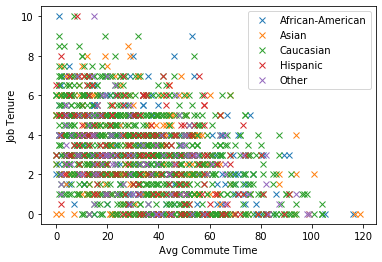

In [10]:
### RUN THIS CELL (4 Lines) ###

# plotFeatureToPerformance - is another printing function that enables us to plot a feature of the dataset
# against a metric to investigate whether there exists some sort of correlation between the two. Each datapoint is further
# coded by its protectedClass identity.
# @params:
#.   - dataset is a dataframe of individuals
#.   - feature is a feature in the dataframe
#.   - metric is a string of one of the three metrics for evaluation - Job Tenure, Avg Deals Closed, or Manager's Assessment Score
#.   - val is an optional array argument you pass in to just plot one or two values that are in the protectedClass (i.e. "Caucasian", "African-American")
# @returns:
#.   - None just plots it out for you.
def plotFeatureToPerformance(dataset, feature, metric, protectedClass, val=None):
    df = dataset.copy()
    if val != None:
        if len(val) == 1:
            df = df.loc[(df[protectedClass] == val[0])]
        elif len(val) == 2:
            df = df.loc[(df[protectedClass]== val[0]) | (df[protectedClass]== val[1])]
    df = df[[feature, metric, protectedClass]]
    groups = df.groupby(protectedClass)
    for name, group in groups:
        plt.plot(group[feature], group[metric], marker="x", linestyle="", label=name)
        
    plt.xlabel(feature)
    plt.ylabel(metric)
    plt.legend()
    
feature = "Avg Commute Time"# INSERT A FEATURE #
metric = "Job Tenure"# SELECT A METRIC #
protectedClass =  "Race"# INSERT A PROTECTED CLASS # 
protectedClass_values = "None" # INSERT up to two values of the protected class you chose #
plotFeatureToPerformance(employees, feature, metric, protectedClass, protectedClass_values)
# plotFeatureToPerformance(candidates, feature, metric, protectedClass) 

### RUN THIS CELL (4 Lines) ###

#### Subtask 3: Dealing with powerful predictors that are biased nonetheless

Finally, sometimes there are features that may be quite helpful and powerful predictors for a particular metric but are nonetheless biased. A high score or value on those features might be very predictive of one of the metrics we care about (e.g. correlation is high between the two) but that feature's distribution seems to rank certain groups over others. 

##### Question: Try and find if a/some feature/s in the set of employees that do track some performance measure quite well (there exists a correlation betwen the feature and the metric), but whose value distribution for a particular group/s is lower than the others causing concern of potential bias . Report your findings

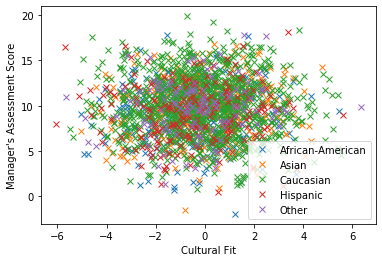

In [13]:
### RUN THIS CELL (4 Lines) ###
# Same function as above can be used to investigate this!
feature = "Cultural Fit"# INSERT A FEATURE #
metric = "Manager's Assessment Score" # SELECT A METRIC #
protectedClass = "Race"# INSERT A PROTECTED CLASS # 
protectedClass_values = "None" # INSERT up to two values of the protected Class you chose #
plotFeatureToPerformance(employees, feature, metric, protectedClass, protectedClass_values)
### RUN THIS CELL (4 Lines) ###

#### Subtask 4: Selecting Features!
Great, so now that your team has an understanding of the features and metrics in this dataset of employees and 
candidates, you've decided to try and use that pre-existing naive ranking model to just test out how the algorithm
might behave. To do this despite some of the biases, you're worried about, you'll have to choose features and weight them depending on how you think they correlate to the kind of performance you want to track. For this little sub-section, your team will go ahead and select some features to use!

##### An aside on one-hotting...
Before we do that though, in data science and machine learning practice it is a common practice to one-hot categorical data. What we mean by that is for a datapoint of a sample whose value represents a particular category it belongs to, we make a new datapoint per category.

So for example currently, race is categorical. But instead of just having one feature or column to representing a candidate's race we transform each sample to have one feature per potential race. So race = "African-American", becomes race_African-American = 1, race_Asian = 0, race_Caucasian = 0, and so on. The code below does that for us for 
each of the categorical features we havein the dataframes.

If you're still confused on what one-hotting is doing, check out this small [piece](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/#:~:text=One%2DHot%20Encoding,-For%20categorical%20variables&text=This%20is%20where%20the%20integer,for%20each%20unique%20integer%20value.&text=The%20binary%20variables%20are%20often,other%20fields%2C%20such%20as%20statistics.)

In [14]:
# Run this Cell (0 Lines) #
# One-hottng the dataset for use
features = ["Race", "Gender", "Birth Origin", "Criminal Record",
           "Arrest Record", "LinkedIn Score", "Responsible Social Media Use", 
            "Sports", "Undergraduate Degree"]
prefixes = ["race", "gender", "origin", "criminal", "arrest", "linkedin", 
           "socmedia", "sports", "degree"]

employees_race = employees["Race"]
candidates_race = candidates["Race"]
sampleEmployees_processed = getOnehottedDataset(employees, features, prefixes)
sampleEmployees_processed["Race"] = employees_race
candidates_processed = getOnehottedDataset(candidates, features, prefixes)
candidates_processed["Race"] = candidates_race

candidates_processed.columns
# Run this Cell #

Index(['Names', 'Age', 'Zip', 'Education', 'GPA', 'Educational Prestige',
       'Years of Experience', 'Soft Skills', 'Manager's Assessment Score',
       'Military Tenure', 'Avg Commute Time', 'Job Tenure', 'Cultural Fit',
       'Leadership Capability', 'HireVue Score', 'Technical Aptitude',
       'Avg Deals Closed', 'Employee Referral', 'race_African-American',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'gender_female', 'gender_male', 'origin_Australia', 'origin_Canada',
       'origin_China', 'origin_Mexico', 'origin_USA', 'criminal_0.0',
       'criminal_1.0', 'arrest_0.0', 'arrest_1.0', 'linkedin_None',
       'linkedin_Ok', 'linkedin_Very Good', 'socmedia_Bad', 'socmedia_Good',
       'sports_0.0', 'sports_1.0', 'sports_2.0', 'degree_Engineering',
       'degree_Humanities', 'degree_Quantitative', 'degree_Sciences', 'Race'],
      dtype='object')

#### Ok, exciting stuff, you've one-hotted your data so lets now choose which features to rank our candidates by. Use your learnings in subtask 1-3 to try and include features you believe are the most effective.

In [15]:
### RUN THIS CELL (1 Line) ### 
# Select your features to use in the ranking model
selectedFeatures = [
    "Military Tenure", "Cultural Fit", "Educational Prestige"
    # Insert features you'd like to use here (e.g. "GPA", "Educational Prestige", "Commute Time")    
]
### RUN THIS CELL (1 Line) ### 

### Task 2: Weighting features
This section is a bit trickier to consider.  Hopefully by now, your team has formulated some intuitions about which features are predictive of measures of an employees' performance (e.g. Manager's Assessment Score, Employee Assessment Score). You've hopefully selected some of those to use in the ranking model in the last task. Here in order to bring our ranking model to operate we're now asking you to formalize those intuitions about the strength of some of the features you chose above by putting a number, or "weight" on these features.  We'll use those weights to calculate the overall score of an employee in the next task.  

Some things to consider.
* Features are not in the same range as usual. Commute time values range anywhere from 5 minutes to 100! Whereas you either have responsible social media use or not ... 

In [18]:
### RUN THIS CELL (1 Line) ### 
weights = {
    "Military Tenure": 1.5, 
    "Cultural Fit": 1.0,
    "Educational Prestige": 2.0
    # INSERT HERE - weights (e.g. "GPA": 1.5, "Military Tenure": 3.0)     
}
### RUN THIS CELL (1 Line) ### 

##### Question: Report the rationale behind your feature selection & weightings (1-2 paragraphs)

### Task 3 & 4: Scoring then Ranking each candidate.

Ok, using the weights and features you've determined you'll now run the cell block below to calculate a score for each candidate.

In [19]:
### RUN THIS CELL (0 Lines) ### 
candidates_scaled = transformDatapointsToScale(candidates_processed, selectedFeatures) # This normalizes the selected features!
candidates_scored = scoreJobCandidates(candidates_scaled, selectedFeatures, weights) # This scores each candidate
candidates_ranked = rankJobCandidates(candidates_scored) # This ranks the candidates
### RUN THIS CELL (0 Lines) ### 

### Task 5: Selecting a percentile cutoff

This last part finalizes our ranking algorithm for hiring. You and your team have to decide what top percentage of candidates are "selected" or move onto the next stage.  We'll illustrate how a decision that seems relatively neutral like this can actually have profound impacts on the characteristics of the selected group given the data.

In [23]:
### RUN THIS CELL (1 Line) ### 
selectionPercentage = .10 # INSERT PERCENTAGE # 
selectedCandidates = selectCandidates(candidates_ranked, selectionPercentage)
### RUN THIS CELL (1 Line) ### 

257           Caucasian
203           Caucasian
476           Caucasian
81            Caucasian
299           Caucasian
270    African-American
352           Caucasian
98                Asian
429           Caucasian
338           Caucasian
244           Caucasian
117           Caucasian
54            Caucasian
278           Caucasian
478           Caucasian
115    African-American
144               Other
390           Caucasian
318               Asian
423               Asian
304           Caucasian
450           Caucasian
38            Caucasian
108           Caucasian
498               Asian
359           Caucasian
322           Caucasian
366               Asian
93            Caucasian
409           Caucasian
354    African-American
226           Caucasian
376               Other
202               Other
154               Asian
279           Caucasian
451           Caucasian
27            Caucasian
358           Caucasian
303           Caucasian
69            Caucasian
361             

### Task 6: Analyzing Title VII Compliance

Now that our algorithm has selected job candidates, we now have to consider the potential title VII liability of automated hiring practices so we need some way to investigate our algorithm's compliance.

* Recall that under the existing federal statutes - there exists three evidentiary frameworks to detect discriminatory intent: direct, indirect, and statistical. (Brookings). We will focus on statistical evidence although we encourage you to repeatedly consider other potential sources of liability. As discussed in lecture, the EEOC has adopted a 4/5ths rule of thumb to quantify a "substantially different rate of selection" that could lend to liability risk under the Title VII apart from a demonstration of business necessity (NEEDS CITATION). The courts have generally upheld the rule.

* The 4/5ths rule states that if the selection rate for a certain group (X) is less than 80 percent of that of the group with the highest selection rate (Y), there is adverse impact on that group (X). 


Fortunately, we've written some code for you to analyze the selection rates of candidates based on the results of this hiring algorithm.  Your team's job is to analyze, whether there exists substantial risk of title VII liability, and if so, to explain where this risk is coming from.

The selection rate for Caucasians:  0.12363636363636364
The selection rate for Asians:  0.12
The selection rate for African-Americans:  0.04285714285714286
The selection rate for Hispanics:  0.0


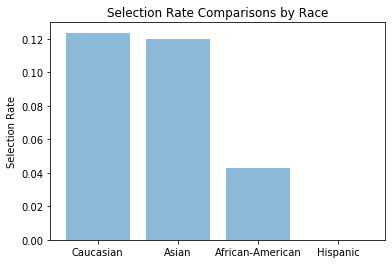

In [25]:
### RUN THIS CELL (0 Lines) ### 
graphSelectionRates(selectedCandidates, candidates_processed, "race")
### RUN THIS CELL (0 Lines) ### 

##### Questions:
 * Based on the last code block, report whether the model produces a disparate impact.
 * Based on your team's algorithm's design and result articulate what risk a disparate impact claim poses. 
 * If your algorithm's results do demonstrate a disparate impact in selection rates, from where in the algorithm's design or in the characteristics of the data have you found it to arise from? Is the bias materially traceable to some characteristic of the dataset? features you selected? You can use the tools in the subtasks to try and investigate skewed distributions, poor feature selection, etc. Report your findings.
 * Try tweaking the selection rate +/- 5, 10 percent, does your team notice any changes? If so, explain why this might be the case.
 
Great, now that we've covered the ranking model and have been exposed to basic disparate impact analysis, let's move 
to the final exercise of milestone 1!



